Experiments

All done! -- Preparing for visualization
Results are exported to 'result003.json'


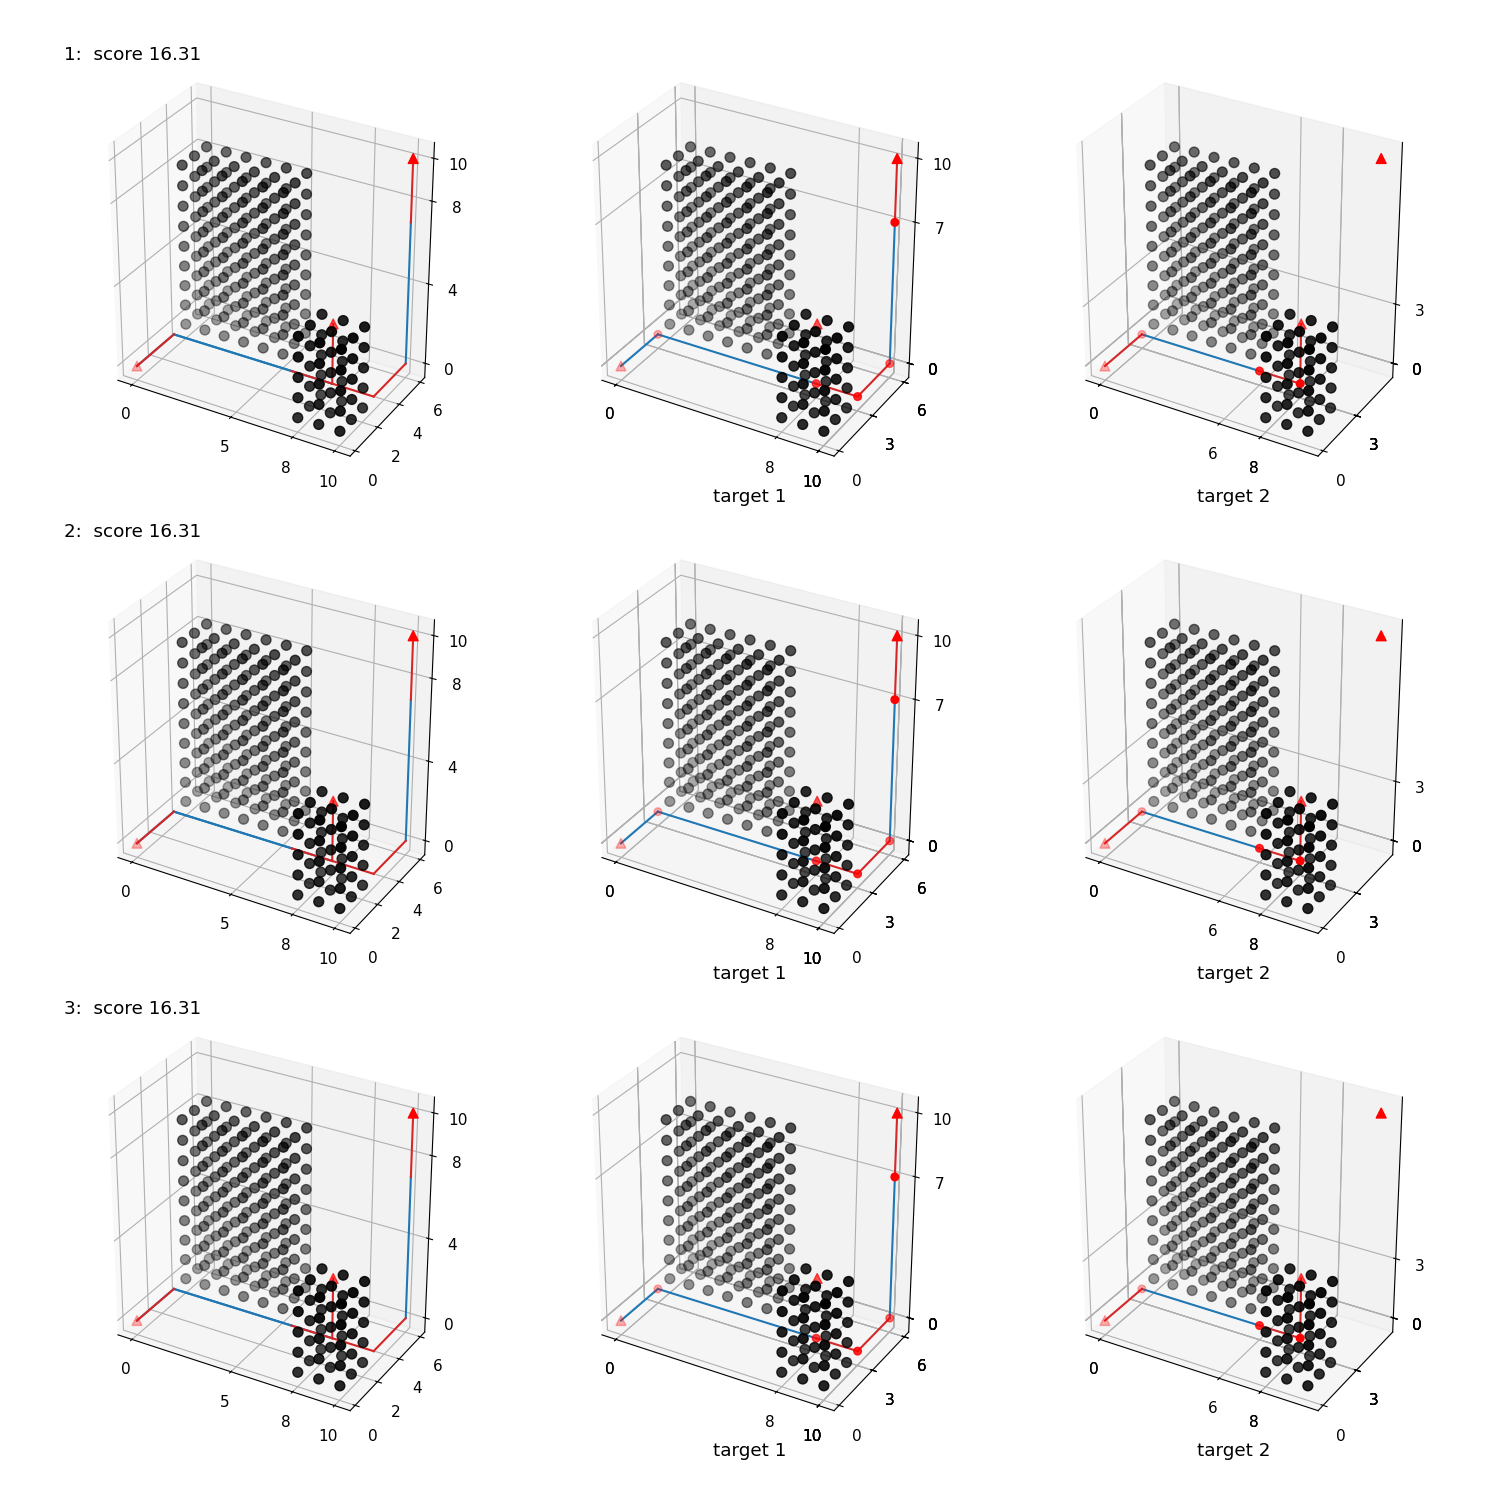

In [30]:
# Baseline
%matplotlib widget
import ga_opt

## 1) Environment setup
# Routing space: Starting pt is always (0,0,0)
targets = [(10,6,10), (8,3,3)] # Primary comes first
obstacles = [(8,2,0,2,2,4), (0,6,0,5,2,8)] # (lower top left corner x, y, z, w, h, d)
stocks = [3,4,4,5,6,6,7,8]
# GA parameters
num_generations = 50
num_population = 50
num_parents_mating = 10
random_prob = 0.8
num_new_p = 0.4
weights = [0.1, 0.2, 0.1, 0.05] # (length, num_of_bending, num_reused_stocks, parallel_piping)

## 2) Result
ga_opt.main(targets, obstacles, stocks, num_generations, num_population, num_parents_mating, random_prob, num_new_p, weights)

All done! -- Preparing for visualization
Results are exported to 'result017.json'


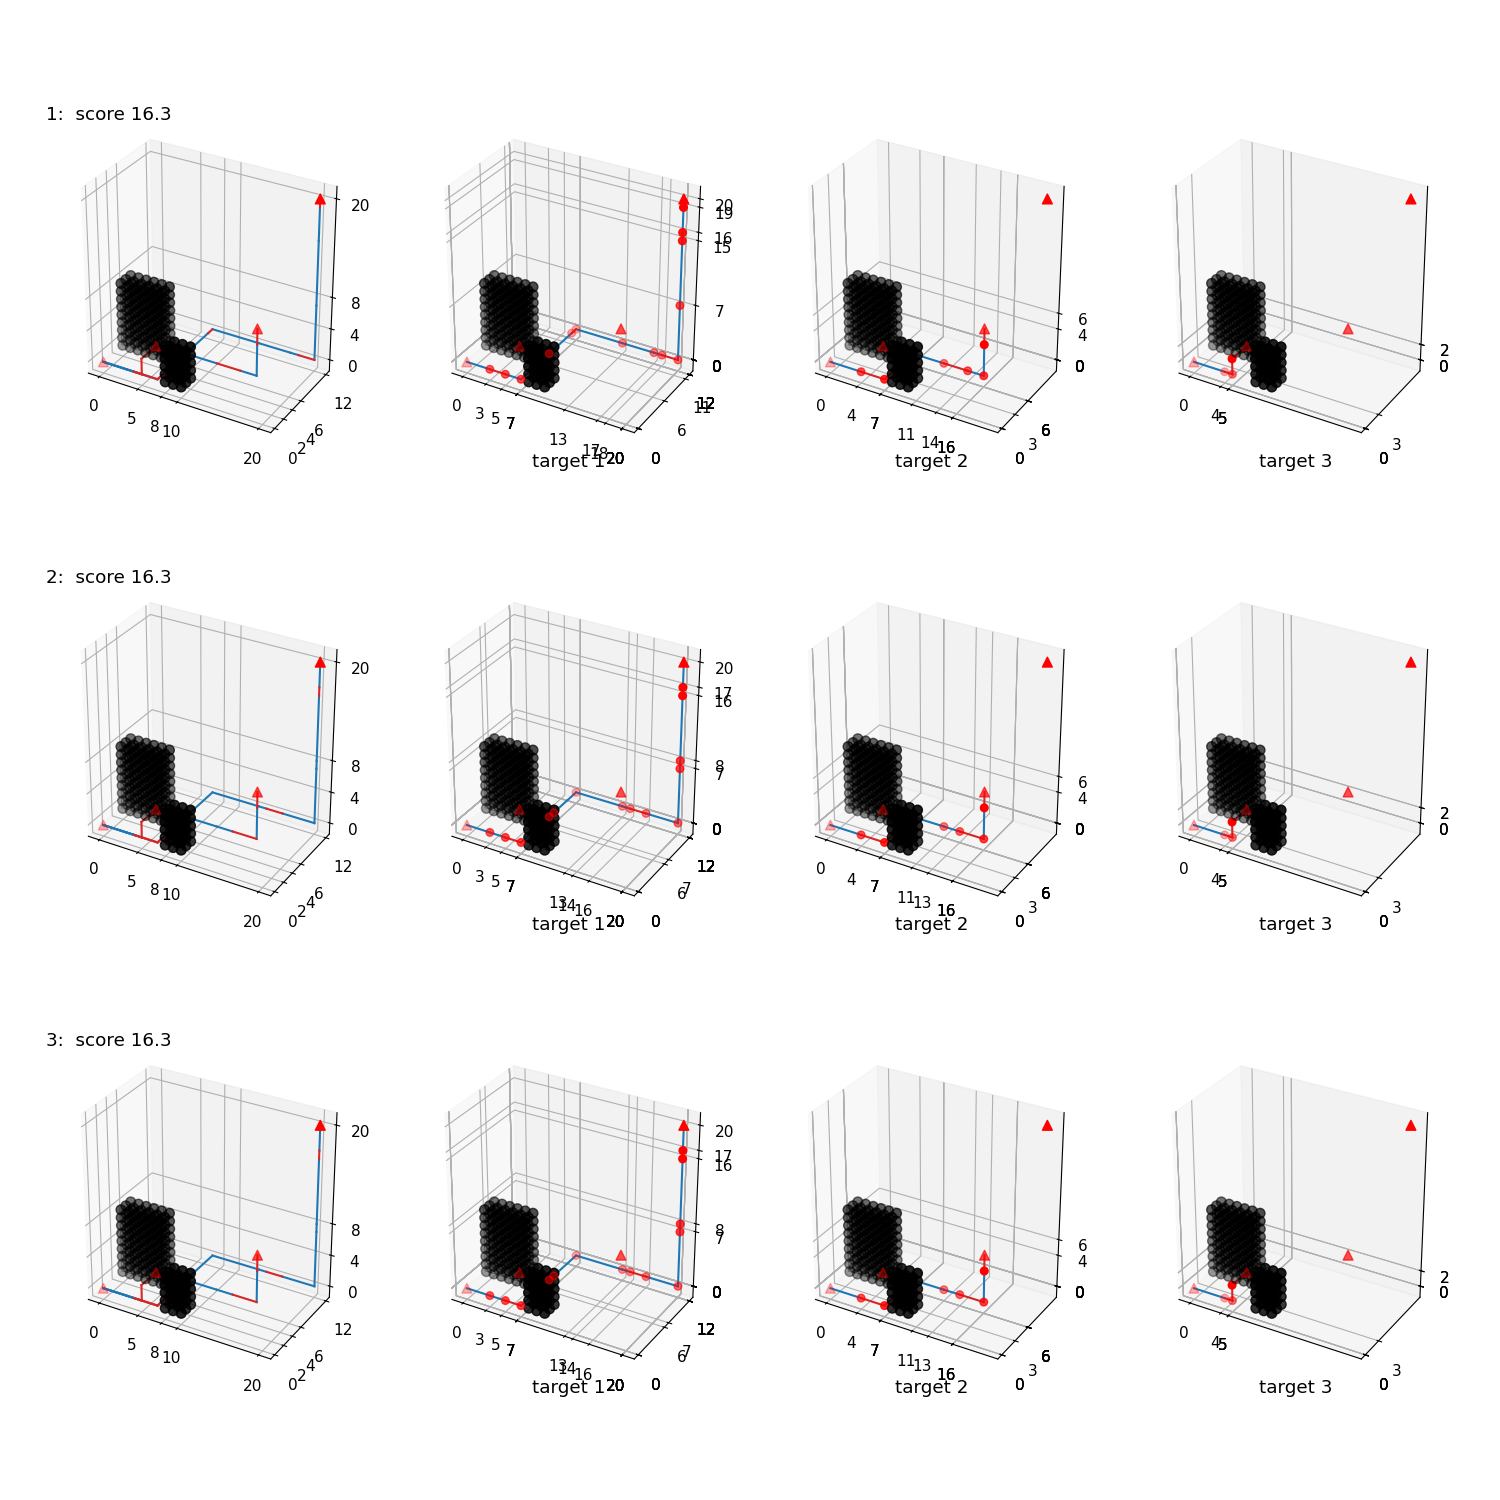

In [48]:
# TryTRy

## 1) Environment setup
# Routing space: Starting pt is always (0,0,0)
targets = [(20,12,20), (16,6,6), (5,3,2)] # Primary comes first
obstacles = [(8,2,0,2,2,4), (0,6,0,5,2,8)] # (lower top left corner x, y, z, w, h, d)
stocks = [3,4,4,5,6,6,7,8]
# GA parameters
num_generations = 50
num_population = 50
num_parents_mating = 10
random_prob = 0.8
num_new_p = 0.4
weights = [0.1, 0.2, 0.1, 0.05] # (length, num_of_bending, num_reused_stocks, parallel_piping)

## 2) Result
ga_opt.main(targets, obstacles, stocks, num_generations, num_population, num_parents_mating, random_prob, num_new_p, weights)

A* Only

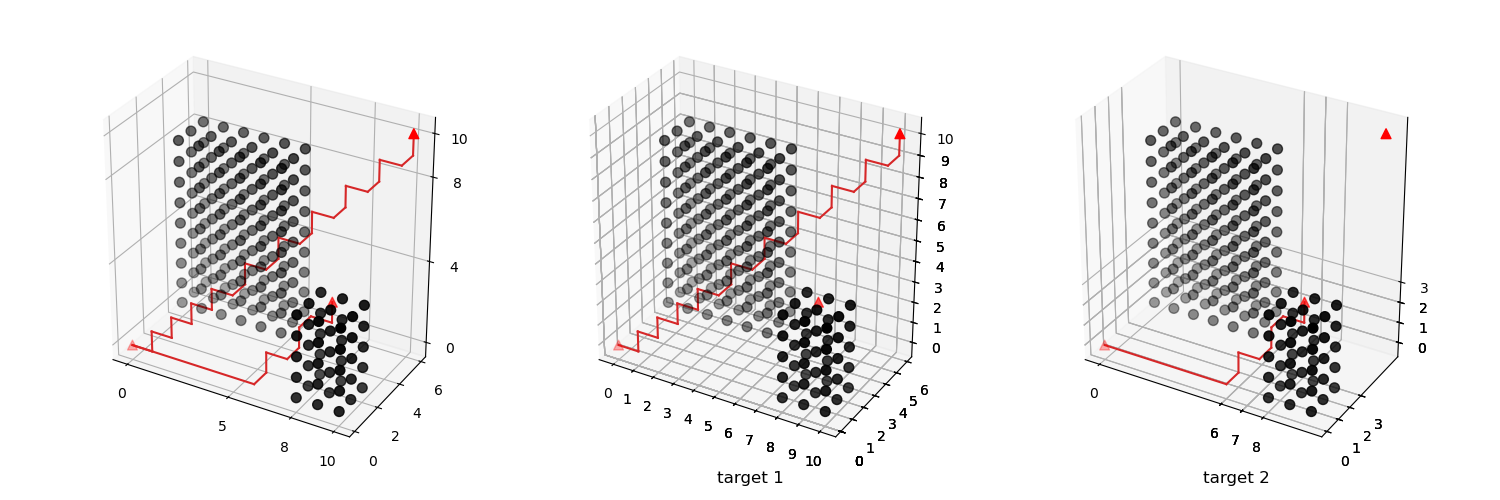

In [ ]:
from heapq import heappop, heappush
from itertools import count
import networkx as nx
from networkx.algorithms.shortest_paths.weighted import _weight_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def initialization(targets, obstacles, path_edges=0):
    G, G_obs = define_env(targets, obstacles)
    path_edges = find_paths(G, targets)
    paths_dir = reorganize_path(path_edges)
    return G, G_obs, paths_dir, path_edges

def reorganize_path(path_edges):
    paths_dir = []
    for target_num, path_by_tar in enumerate(path_edges):
        path1_dir = []
        for i, (u,v) in enumerate(path_by_tar):
            temp_dir = np.array(list(v))-np.array(list(u))
            cur_dir = list((np.nonzero(temp_dir)[0]+1)*temp_dir[temp_dir != 0])[0]  # (nonzero_index)*(dir)
            if i==0:
                org_dir = cur_dir
                temp_len, order = 0, 1
            elif org_dir != cur_dir:
                path1_dir.append((org_dir, temp_len+1, 2, target_num, order))
                org_dir = cur_dir
                temp_len = 0
                order += 1
            else:
                temp_len += 1
        path1_dir.append((org_dir, temp_len+1, 2, target_num, order)) # Append the missing last edge
        paths_dir.append(path1_dir)
    return paths_dir

def define_env(graph_dim, obstacles):
    # Define an initial graph G
    (x1, y1, z1) = graph_dim[0]
    G = nx.grid_graph(dim=(z1+1, y1+1, x1+1)) # It's wierd but should be in (y,x) order!
    # Add obstacle information to the initial graph G
    obstacle_nodes_integrated = []
    obstacle_nodes = obs_nodes(obstacles)
    obstacle_nodes_integrated.extend(obstacle_nodes)
    # obstacle_nodes = obs_nodes(obstacles)
    G_obs = G.subgraph(obstacle_nodes)
    G2 = add_nodes_cost(G, G_obs, 100000)
    return G2, G_obs

def find_paths(G, targets):
    path_edges = []
    for target in targets:
        result = astar_path(G, (0,0,0), target, heuristic=distance, weight='weight') # Returns a list of nodes
        path1 = []
        pair = [result[0]]
        for node in result[1:]:
            pair.append(node)
            path1.append(tuple(pair))
            pair = [node]
        path_edges.append(path1)
    return path_edges

def distance(a, b):
    (x1, y1, z1) = a
    (x2, y2, z2) = b
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2 + (z1 - z2) ** 2) ** 0.5

def astar_path(G, source, target, heuristic=None, weight="weight"):
    if source not in G or target not in G:
        msg = f"Either source {source} or target {target} is not in G"
        raise nx.NodeNotFound(msg)
    if heuristic is None:
        # The default heuristic is h=0 - same as Dijkstra's algorithm
        def heuristic(u, v):
            return 0

    push = heappush
    pop = heappop
    weight = _weight_function(G, weight)

    G_succ = G._adj
    c = count()

    queue = [(0, next(c), source, 0, None)]
    enqueued, explored = {}, {}

    while queue:
        # Pop the smallest item from queue.
        _, __, curnode, dist, parent = pop(queue)

        if curnode == target:
            path = [curnode]
            node = parent
            while node is not None:
                path.append(node)
                node = explored[node]
            path.reverse()
            return path

        if curnode in explored:
            # Do not override the parent of starting node
            if explored[curnode] is None:
                continue

            # Skip bad paths that were enqueued before finding a better one
            qcost, h = enqueued[curnode]
            if qcost < dist:
                continue

        explored[curnode] = parent

        for neighbor, w in G_succ[curnode].items():
            cost = weight(curnode, neighbor, w)
            if cost is None:
                continue
            ncost = dist + cost
            if neighbor in enqueued:
                qcost, h = enqueued[neighbor]
                # if qcost <= ncost, a less costly path from the
                # neighbor to the source was already determined.
                # Therefore, we won't attempt to push this neighbor
                # to the queue
                if qcost <= ncost:
                    continue
            else:
                h = distance(neighbor, target)
                h = h*ncost

            enqueued[neighbor] = ncost, h
            push(queue, (ncost + h, next(c), neighbor, ncost, curnode))

    raise nx.NetworkXNoPath(f"Node {target} not reachable from {source}")

def obs_nodes(obstacles):
    result = []
    for obs in obstacles: # obs = (x, y, z, w, h, d): lower top left corner
        x, y, z, w, h, d = obs
        for i in range(w+1):
            for j in range(h+1):
                for k in range (d+1):
                    result.append((x+i, y-j, z+k))
    return result

def add_nodes_cost(G, G_obs, w):
    for (u, v) in list(G_obs.edges()):
        G.edges[u, v]['weight'] = w
        (x1, y1, z1) = u
        if x1 > 1:
            G.edges[(x1-1, y1, z1), (x1,y1, z1)]['weight'] = w
        if y1 > 1:
            G.edges[(x1, y1-1, z1), (x1,y1, z1)]['weight'] = w
        if z1 > 1:
            G.edges[(x1, y1, z1-1), (x1,y1, z1)]['weight'] = w
    return G

def vizresult(G, G_obs, targets, obstacles, result):   
    # Pre-process environment and paths
    node_xyz_obs = np.array(G_obs)
    s_ts = targets.copy()
    s_ts.append((0,0,0))
    node_xyz_st = np.array(s_ts)
    ratio = (targets[0][0], targets[0][1], targets[0][2])
    fig = plt.figure(figsize=(15,5))

    # Pre-process xyz-ticks
    xticks, yticks, zticks = [0,ratio[0]], [ratio[1]], [ratio[2]]
    for obs in obstacles:
        x, y, z, w, h, d = obs    # lower top left corner
        xticks.extend([x, x+w])
        yticks.extend([y, y-h])
        zticks.extend([z, z+d])
    xticks, yticks, zticks = list(set(xticks)), list(set(yticks)), list(set(zticks))

    ax = Axes3D(fig)
    ax = fig.add_subplot(1, 3, 1, projection="3d")
    ax.set_box_aspect(ratio)
    ax.scatter(*node_xyz_obs.T, s=50, c="k", zorder=2)
    ax.scatter(*node_xyz_st.T, s=50, c="r", marker='^', zorder=2)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_zticks(zticks)

    for tari, path_by_tar in enumerate(result):
        # Draw basic pts and edges
        ax2 = fig.add_subplot(1, 3, 2+tari, projection="3d")
        ax2.set_box_aspect(ratio)
        ax2.scatter(*node_xyz_obs.T, s=50, c="k", zorder=2)
        ax2.scatter(*node_xyz_st.T, s=50, c="r", marker='^', zorder=2)
        ax2.set_title(f'target {tari+1}', y=-0.1)
        pts, re_edges= stock2path(path_by_tar)
        for vizedge in re_edges:
            ax2.plot(*np.array(vizedge).T, color="tab:red", zorder=1)
            ax.plot(*np.array(vizedge).T, color="tab:red", zorder=1)
        ax2.set_xticks([x[0] for x in pts])
        ax2.set_yticks([x[1] for x in pts])
        ax2.set_zticks([x[2] for x in pts])

    # Show the funal figure
    fig.tight_layout(pad=3)
    plt.show()
    return

def stock2path(path_by_tar):
    pts, re_edges = [[0,0,0]], []
    for stock in path_by_tar:
        pt = pts[-1].copy()
        if stock[0] > 0:
            # (Direction_x1/y2/z3, Length, Reused:1/Undefined:2, target_num, order)
            pt[stock[0]-1] += stock[1]
        else:
            pt[-stock[0]-1] -= stock[1]
        pts.append(pt)
        re_edges.append(pts[-2:])
    return pts, re_edges



%matplotlib widget

targets = [(10,6,10), (8,3,3)] # Primary comes first
obstacles = [(8,2,0,2,2,4), (0,6,0,5,2,8)] # (lower top left corner x, y, z, w, h, d)
stocks = [3,4,4,5,6,6,7,8]

G, G_obs, paths_dir, path_edges = initialization(targets, obstacles)
vizresult(G, G_obs, targets, obstacles, paths_dir)

Improved A*

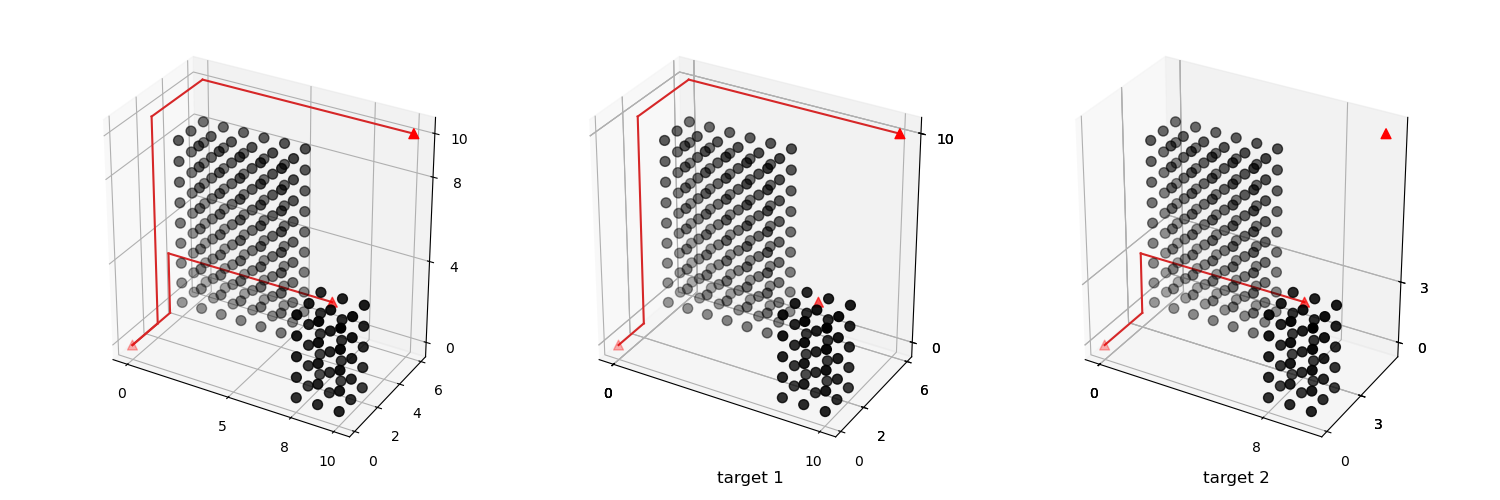

In [ ]:
from heapq import heappop, heappush
from itertools import count
import networkx as nx
from networkx.algorithms.shortest_paths.weighted import _weight_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def initialization(targets, obstacles, path_edges=0):
    G, G_obs = define_env(targets, obstacles)
    path_edges = find_paths(G, targets)
    paths_dir = reorganize_path(path_edges)
    return G, G_obs, paths_dir, path_edges

def reorganize_path(path_edges):
    paths_dir = []
    for target_num, path_by_tar in enumerate(path_edges):
        path1_dir = []
        for i, (u,v) in enumerate(path_by_tar):
            temp_dir = np.array(list(v))-np.array(list(u))
            cur_dir = list((np.nonzero(temp_dir)[0]+1)*temp_dir[temp_dir != 0])[0]  # (nonzero_index)*(dir)
            if i==0:
                org_dir = cur_dir
                temp_len, order = 0, 1
            elif org_dir != cur_dir:
                path1_dir.append((org_dir, temp_len+1, 2, target_num, order))
                org_dir = cur_dir
                temp_len = 0
                order += 1
            else:
                temp_len += 1
        path1_dir.append((org_dir, temp_len+1, 2, target_num, order)) # Append the missing last edge
        paths_dir.append(path1_dir)
    return paths_dir

def define_env(graph_dim, obstacles):
    # Define an initial graph G
    (x1, y1, z1) = graph_dim[0]
    G = nx.grid_graph(dim=(z1+1, y1+1, x1+1)) # It's wierd but should be in (y,x) order!
    # Add obstacle information to the initial graph G
    obstacle_nodes_integrated = []
    obstacle_nodes = obs_nodes(obstacles)
    obstacle_nodes_integrated.extend(obstacle_nodes)
    # obstacle_nodes = obs_nodes(obstacles)
    G_obs = G.subgraph(obstacle_nodes)
    G2 = add_nodes_cost(G, G_obs, 100000)
    return G2, G_obs

def find_paths(G, targets):
    path_edges = []
    for target in targets:
        result = astar_path(G, (0,0,0), target, heuristic=final_cost, weight='weight') # Returns a list of nodes
        path1 = []
        pair = [result[0]]
        for node in result[1:]:
            pair.append(node)
            path1.append(tuple(pair))
            pair = [node]
        path_edges.append(path1)
    return path_edges

def final_cost(neighbor, target, parent, curnode):
    if parent == None:
        parent = curnode
    (x1, y1, z1) = neighbor
    (x2, y2, z2) = target
    (x3, y3, z3) = parent
    (x4, y4, z4) = curnode

    direction_p2c = cal_direction([x4-x3, y4-y3, z4-z3])
    direction_c2n = cal_direction([x1-x4, y1-y4, z1-z4])
    direction_n2t = cal_direction([x2-x1, y2-y1, z2-z1])

    h = 1
    w = 0
    if direction_p2c != direction_c2n:
        h += (3+w)*len(direction_n2t)
    elif direction_c2n[0] in direction_n2t:
        h += (1+w)*(len(direction_n2t)-1)
    else:
        h += (1+w)*len(direction_n2t)

    return h

def astar_path(G, source, target, heuristic=None, weight="weight"):
    if source not in G or target not in G:
        msg = f"Either source {source} or target {target} is not in G"
        raise nx.NodeNotFound(msg)

    if heuristic is None:
        # The default heuristic is h=0 - same as Dijkstra's algorithm
        def heuristic(u, v, z, w):
            return 0

    push = heappush
    pop = heappop
    weight = _weight_function(G, weight)

    G_succ = G._adj  # For speed-up (and works for both directed and undirected graphs)

    # The queue stores priority, node, cost to reach, and parent.
    # Uses Python heapq to keep in priority order.
    # Add a counter to the queue to prevent the underlying heap from
    # attempting to compare the nodes themselves. The hash breaks ties in the
    # priority and is guaranteed unique for all nodes in the graph.
    c = count()
    queue = [(0, next(c), source, 0, None)]

    # Maps enqueued nodes to distance of discovered paths and the
    # computed heuristics to target. We avoid computing the heuristics
    # more than once and inserting the node into the queue too many times.
    enqueued = {}
    # Maps explored nodes to parent closest to the source.
    explored = {}

    while queue:
        # Pop the smallest item from queue.
        _, __, curnode, dist, parent = pop(queue)

        if curnode == target:
            path = [curnode]
            node = parent
            while node is not None:
                path.append(node)
                node = explored[node]
            path.reverse()
            return path

        if curnode in explored:
            # Do not override the parent of starting node
            if explored[curnode] is None:
                continue

            # Skip bad paths that were enqueued before finding a better one
            qcost, h = enqueued[curnode]
            if qcost < dist:
                continue

        explored[curnode] = parent

        for neighbor, w in G_succ[curnode].items():
            cost = weight(curnode, neighbor, w)
            if cost is None:
                continue
            ncost = dist + cost
            if neighbor in enqueued:
                qcost, h = enqueued[neighbor]
                # if qcost <= ncost, a less costly path from the
                # neighbor to the source was already determined.
                # Therefore, we won't attempt to push this neighbor
                # to the queue
                if qcost <= ncost:
                    continue
            else:
                h = heuristic(neighbor, target, parent, curnode)
                h = h*ncost

            enqueued[neighbor] = ncost, h
            push(queue, (ncost + h, next(c), neighbor, ncost, curnode))

    raise nx.NetworkXNoPath(f"Node {target} not reachable from {source}")

def obs_nodes(obstacles):
    result = []
    for obs in obstacles: # obs = (x, y, z, w, h, d): lower top left corner
        x, y, z, w, h, d = obs
        for i in range(w+1):
            for j in range(h+1):
                for k in range (d+1):
                    result.append((x+i, y-j, z+k))
    return result

def add_nodes_cost(G, G_obs, w):
    for (u, v) in list(G_obs.edges()):
        G.edges[u, v]['weight'] = w
        (x1, y1, z1) = u
        if x1 > 1:
            G.edges[(x1-1, y1, z1), (x1,y1, z1)]['weight'] = w
        if y1 > 1:
            G.edges[(x1, y1-1, z1), (x1,y1, z1)]['weight'] = w
        if z1 > 1:
            G.edges[(x1, y1, z1-1), (x1,y1, z1)]['weight'] = w
    return G

def cal_direction(xyz):
    my_direction = []
    for i, val in enumerate(xyz):
        if val != 0:
            my_direction.append(i)
    return my_direction

def vizresult(G, G_obs, targets, obstacles, result):   
    # Pre-process environment and paths
    node_xyz_obs = np.array(G_obs)
    s_ts = targets.copy()
    s_ts.append((0,0,0))
    node_xyz_st = np.array(s_ts)
    ratio = (targets[0][0], targets[0][1], targets[0][2])
    fig = plt.figure(figsize=(15,5))

    # Pre-process xyz-ticks
    xticks, yticks, zticks = [0,ratio[0]], [ratio[1]], [ratio[2]]
    for obs in obstacles:
        x, y, z, w, h, d = obs    # lower top left corner
        xticks.extend([x, x+w])
        yticks.extend([y, y-h])
        zticks.extend([z, z+d])
    xticks, yticks, zticks = list(set(xticks)), list(set(yticks)), list(set(zticks))

    ax = Axes3D(fig)
    ax = fig.add_subplot(1, 3, 1, projection="3d")
    ax.set_box_aspect(ratio)
    ax.scatter(*node_xyz_obs.T, s=50, c="k", zorder=2)
    ax.scatter(*node_xyz_st.T, s=50, c="r", marker='^', zorder=2)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_zticks(zticks)

    for tari, path_by_tar in enumerate(result):
        # Draw basic pts and edges
        ax2 = fig.add_subplot(1, 3, 2+tari, projection="3d")
        ax2.set_box_aspect(ratio)
        ax2.scatter(*node_xyz_obs.T, s=50, c="k", zorder=2)
        ax2.scatter(*node_xyz_st.T, s=50, c="r", marker='^', zorder=2)
        ax2.set_title(f'target {tari+1}', y=-0.1)
        pts, re_edges= stock2path(path_by_tar)
        for vizedge in re_edges:
            ax2.plot(*np.array(vizedge).T, color="tab:red", zorder=1)
            ax.plot(*np.array(vizedge).T, color="tab:red", zorder=1)
        ax2.set_xticks([x[0] for x in pts])
        ax2.set_yticks([x[1] for x in pts])
        ax2.set_zticks([x[2] for x in pts])

    # Show the funal figure
    fig.tight_layout(pad=3)
    plt.show()
    return

def stock2path(path_by_tar):
    pts, re_edges = [[0,0,0]], []
    for stock in path_by_tar:
        pt = pts[-1].copy()
        if stock[0] > 0:
            # (Direction_x1/y2/z3, Length, Reused:1/Undefined:2, target_num, order)
            pt[stock[0]-1] += stock[1]
        else:
            pt[-stock[0]-1] -= stock[1]
        pts.append(pt)
        re_edges.append(pts[-2:])
    return pts, re_edges



%matplotlib widget

targets = [(10,6,10), (8,3,3)] # Primary comes first
obstacles = [(8,2,0,2,2,4), (0,6,0,5,2,8)] # (lower top left corner x, y, z, w, h, d)
stocks = [3,4,4,5,6,6,7,8]

G, G_obs, paths_dir, path_edges = initialization(targets, obstacles)
vizresult(G, G_obs, targets, obstacles, paths_dir)

Without GA

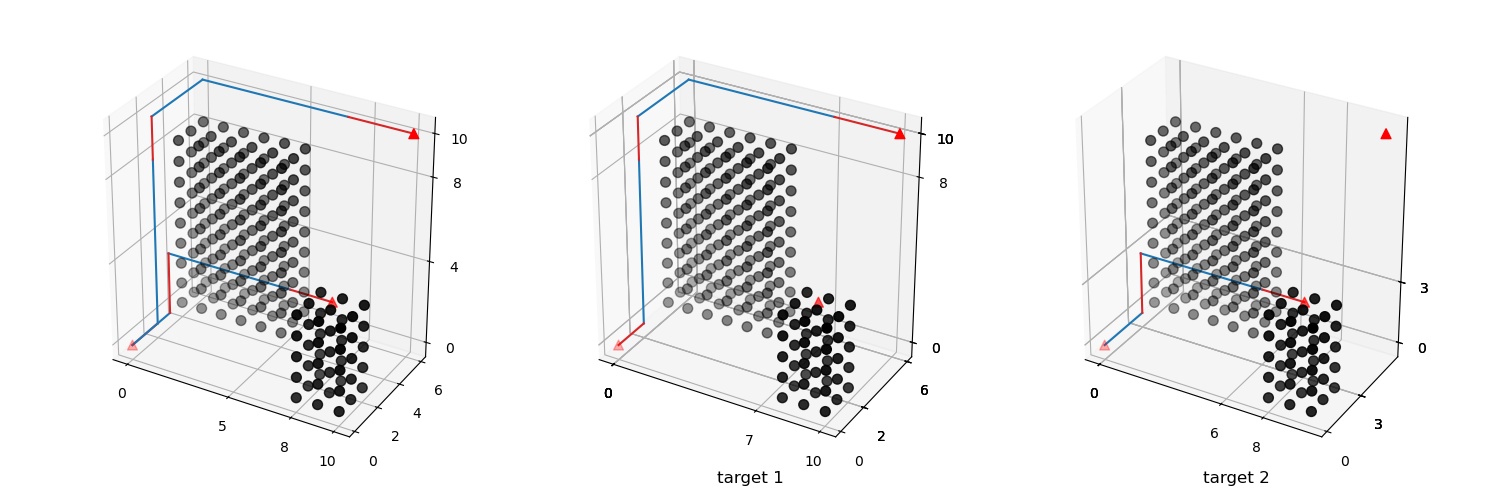

In [ ]:
def stock_total(paths_dir, stocks):
    paths_dir_flat = []
    for paths in paths_dir:
        for path in paths:
            paths_dir_flat.append(path)
    # Assign stocks    
    sorted_paths_dir = sorted(paths_dir_flat, key=lambda x: x[1], reverse=True)
    new_paths_dir = assign_stocks(sorted_paths_dir, stocks)
    # Re-order the stocks
    paths_dir2, temp = {}, []
    paths_dir2, temp = sort_path_by_target(new_paths_dir, paths_dir2, temp)
    return paths_dir2

def assign_stocks(rem_paths_dir, rem_stocks):
    new_paths_dir = []
    rem_stocks1 = rem_stocks.copy()
    for stock in sorted(rem_stocks1, reverse=True):
        for path in rem_paths_dir:
            if stock == path[1]:
                new_paths_dir.append((path[0], stock, 1, path[3], path[4]))
                rem_paths_dir.remove(path)
                rem_stocks1.remove(stock)
                break
            elif stock < path[1]:
                temp_path = (path[0], path[1]-stock, path[2], path[3], path[4]+0.1)
                new_paths_dir.append((path[0], stock, 1, path[3], path[4]))
                rem_paths_dir.remove(path)
                rem_paths_dir.append(temp_path)
                rem_stocks1.remove(stock)
                break
    new_paths_dir.extend(rem_paths_dir)
    return new_paths_dir

def sort_path_by_target(paths_dir, paths_dir2, temp):
    for path in paths_dir: # paths_dir2 = {target_num: [path1, path2, ], ...}
        if path[3] not in temp:
            paths_dir2[path[3]] = [path]
            temp.append(path[3])
        else:
            paths_dir2[path[3]].append(path)
            paths_dir2[path[3]] = sorted(paths_dir2[path[3]], key=lambda x: x[4])
    return paths_dir2, temp

def stock2path_(path_by_tar):
    pts, re_edges, non_re = [[0,0,0]], [], []
    for stock in path_by_tar:
        pt = pts[-1].copy()
        if stock[0] > 0:
            # (Direction_x1/y2/z3, Length, Reused:1/Undefined:2, target_num, order)
            pt[stock[0]-1] += stock[1]
        else:
            pt[-stock[0]-1] -= stock[1]
        pts.append(pt)
        if stock[2] == 1:
            re_edges.append(pts[-2:])
        else:
            non_re.append(pts[-2:])
    return pts, re_edges, non_re

def vizresult2(G_obs, targets, obstacles, result):
    # Pre-process environment and paths
    node_xyz_obs = np.array(G_obs)
    s_ts = targets.copy()
    s_ts.append((0,0,0))
    node_xyz_st = np.array(s_ts)
    ratio = (targets[0][0], targets[0][1], targets[0][2])
    fig = plt.figure(figsize=(15,5))

    # Pre-process xyz-ticks
    xticks, yticks, zticks = [0,ratio[0]], [ratio[1]], [ratio[2]]
    for obs in obstacles:
        x, y, z, w, h, d = obs
        xticks.extend([x, x+w])
        yticks.extend([y, y-h])
        zticks.extend([z, z+d])
    xticks, yticks, zticks = list(set(xticks)), list(set(yticks)), list(set(zticks))

    ax = Axes3D(fig)
    ax = fig.add_subplot(1, 3, 1, projection="3d")
    ax.set_box_aspect(ratio)
    ax.scatter(*node_xyz_obs.T, s=50, c="k", zorder=2)
    ax.scatter(*node_xyz_st.T, s=50, c="r", marker='^', zorder=2)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_zticks(zticks)

    result = [result[0], result[1]]

    for tari, path_by_tar in enumerate(result):
        # Draw basic pts and edges
        ax2 = fig.add_subplot(1, 3, 2+tari, projection="3d")
        ax2.set_box_aspect(ratio)
        ax2.scatter(*node_xyz_obs.T, s=50, c="k", zorder=2)
        ax2.scatter(*node_xyz_st.T, s=50, c="r", marker='^', zorder=2)
        ax2.set_title(f'target {tari+1}', y=-0.1)
        pts, re_edges, non_re = stock2path_(path_by_tar)
        for vizedge in re_edges:
            ax2.plot(*np.array(vizedge).T, color="tab:blue", zorder=1)
            ax.plot(*np.array(vizedge).T, color="tab:blue", zorder=1)
        for vizedge in non_re:
            ax2.plot(*np.array(vizedge).T, color="tab:red", zorder=1)
            ax.plot(*np.array(vizedge).T, color="tab:red", zorder=1)
        ax2.set_xticks([x[0] for x in pts])
        ax2.set_yticks([x[1] for x in pts])
        ax2.set_zticks([x[2] for x in pts])

    # Show the funal figure
    fig.tight_layout(pad=3)
    plt.show()
    return



%matplotlib widget

targets = [(10,6,10), (8,3,3)] # Primary comes first
obstacles = [(8,2,0,2,2,4), (0,6,0,5,2,8)] # (lower top left corner x, y, z, w, h, d)
stocks = [3,4,4,5,6,6,7,8]

G, G_obs, paths_dir, path_edges = initialization(targets, obstacles)
result = stock_total(paths_dir, stocks)
vizresult2(G_obs, targets, obstacles, result)

Environment setting

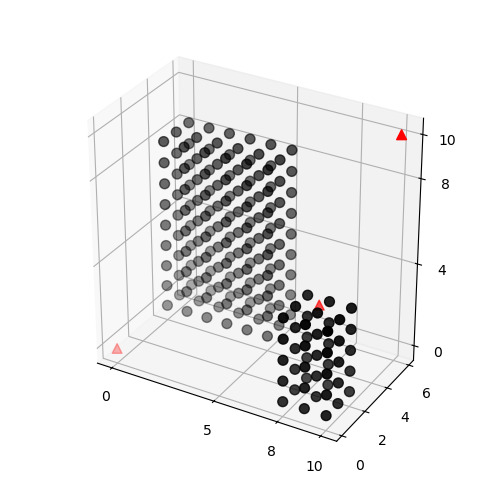

In [ ]:
%matplotlib widget

import numpy as np
import random, math
import json
import os, glob, time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pathfinding


def vizresult2(targets, obstacles):
    G, G_obs = pathfinding.define_env(targets, obstacles)
    # Pre-process environment and paths
    node_xyz_obs = np.array(G_obs)
    s_ts = targets.copy()
    s_ts.append((0,0,0))
    node_xyz_st = np.array(s_ts)
    ratio = (targets[0][0], targets[0][1], targets[0][2])

    fig = plt.figure(figsize=(5,5))

    # Pre-process xyz-ticks
    xticks, yticks, zticks = [0,ratio[0]], [ratio[1]], [ratio[2]]
    for obs in obstacles:
        x, y, z, w, h, d = obs    # lower top left corner
        xticks.extend([x, x+w])
        yticks.extend([y, y-h])
        zticks.extend([z, z+d])
    xticks, yticks, zticks = list(set(xticks)), list(set(yticks)), list(set(zticks))

    # Draw the integrated plot
    ax = Axes3D(fig)
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    ax.set_box_aspect(ratio)
    ax.scatter(*node_xyz_obs.T, s=50, c="k", zorder=2)
    ax.scatter(*node_xyz_st.T, s=50, c="r", marker='^', zorder=2)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_zticks(zticks)

    # Show the funal figure
    fig.tight_layout(pad=3)
    plt.show()
    return

targets = [(10,6,10), (8,3,3)] # Primary comes first
obstacles = [(8,2,0,2,2,4), (0,6,0,5,2,8)] 
vizresult2(targets, obstacles)

Convergence

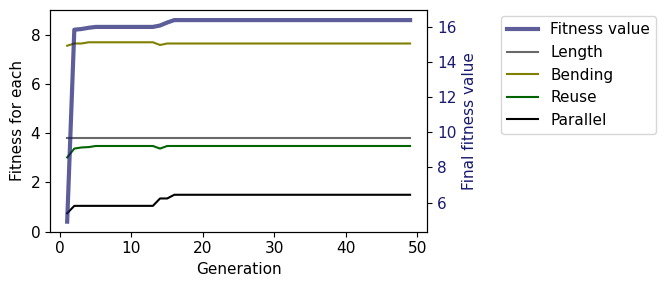

In [25]:
import json, re, os
import matplotlib.pyplot as plt
import numpy as np

fname = r"result002.json"

root = r"C:\Users\ss226456\Documents\Projects\2024_ERCpjt\02_Works\result"
full_fname = os.path.join(root, fname)
with open(full_fname, 'r') as f:
    j_parsed = json.load(f)

f_, fls, fbs, frs, fps = [], [], [], [], []
cpts = j_parsed["Checkpoints"]
gens = [int(re.findall('\d+', g)[-1]) for g in list(cpts.keys())]
gens_num = list(range(1, max(gens)+1))
weights = np.array([0.4, 0.4, 0.1, 0.1])

def updateData(ff, fl, fb, fr, fp, f_, fls, fbs, frs, fps):
    f_.append(ff)
    fls.append(float(fl))
    fbs.append(float(fb))
    frs.append(float(fr))
    fps.append(float(fp))
    return f_, fls, fbs, frs, fps

for geni in gens_num:
    if geni in gens:
        cpt = cpts[f"Generation{geni}"]
        feach = re.sub(' +', ' ', cpt['Fitness_Length, Bending, Reuse, Parallel'])
        fl, fb, fr, fp = [float(val) for val in re.split('[\s*]', feach[1:-1].strip())]
        if geni == 1:
            ff = np.round(np.dot(weights, np.array([fl, fb, fr, fp]).T), 2)
        else:
            ff = round(cpt['Fitness'], 2)
        f_, fls, fbs, frs, fps = updateData(ff, fl, fb, fr, fp, f_, fls, fbs, frs, fps)
    else:
        f_, fls, fbs, frs, fps = updateData(ff, fl, fb, fr, fp, f_, fls, fbs, frs, fps)


fig, ax1 = plt.subplots(figsize = (5,3))
plt.rcParams.update({'font.size': 11})


colorf_, colorfls, colorfbs, colorfrs, colorfps = 'midnightblue', 'dimgray', 'olive', 'darkgreen', 'black'

ax1.set_xlabel('Generation')
ax1.set_ylabel('Fitness for each', color=colorfps)
linefrs, = ax1.plot(gens_num, frs, color=colorfrs, label='Reuse')
linefps, = ax1.plot(gens_num, fps, color=colorfps, label='Parallel')
linefls, = ax1.plot(gens_num, fls, color=colorfls, label='Length')
linefbs, = ax1.plot(gens_num, fbs, color=colorfbs, label='Bending')
ax1.tick_params(axis='y', labelcolor=colorfps)
ax1.set_ylim([0,9])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Final fitness value', color=colorf_)
linef_, = ax2.plot(gens_num, f_, linewidth=3, color=colorf_, label='Fitness value', alpha=0.7)
ax2.tick_params(axis='y', labelcolor=colorf_)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend([linef_, linefls, linefbs, linefrs, linefps], 
           ['Fitness value', 'Length', 'Bending', 'Reuse', 'Parallel'], bbox_to_anchor=(1, 0.95), loc='upper left')
plt.savefig(f'{root}\{fname.split(".")[0]}_plotted.png', bbox_inches='tight')
plt.show()

Bigger Fig for poster

In [8]:
from heapq import heappop, heappush
from itertools import count
import networkx as nx
from networkx.algorithms.shortest_paths.weighted import _weight_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def define_env(graph_dim, obstacles):
    # Define an initial graph G
    (x1, y1, z1) = graph_dim[0]
    G = nx.grid_graph(dim=(z1+1, y1+1, x1+1)) # It's wierd but should be in (y,x) order!
    # Add obstacle information to the initial graph G
    obstacle_nodes_integrated = []
    obstacle_nodes = obs_nodes(obstacles)
    obstacle_nodes_integrated.extend(obstacle_nodes)
    # obstacle_nodes = obs_nodes(obstacles)
    G_obs = G.subgraph(obstacle_nodes)
    return G_obs

def obs_nodes(obstacles):
    result = []
    for obs in obstacles: # obs = (x, y, z, w, h, d): lower top left corner
        x, y, z, w, h, d = obs
        for i in range(w+1):
            for j in range(h+1):
                for k in range (d+1):
                    result.append((x+i, y-j, z+k))
    return result

def vizresult(G_obs, targets, obstacles, result):   
    # Pre-process environment and paths
    node_xyz_obs = np.array(G_obs)
    s_ts = targets.copy()
    s_ts.append((0,0,0))
    node_xyz_st = np.array(s_ts)
    ratio = (targets[0][0], targets[0][1], targets[0][2])
    fig = plt.figure(figsize=(40,15))

    # Pre-process xyz-ticks
    xticks, yticks, zticks = [0,ratio[0]], [ratio[1]], [ratio[2]]
    for obs in obstacles:
        x, y, z, w, h, d = obs    # lower top left corner
        xticks.extend([x, x+w])
        yticks.extend([y, y-h])
        zticks.extend([z, z+d])
    xticks, yticks, zticks = list(set(xticks)), list(set(yticks)), list(set(zticks))

    ax = Axes3D(fig)
    ax = fig.add_subplot(1, 3, 1, projection="3d")
    ax.set_box_aspect(ratio)
    ax.scatter(*node_xyz_obs.T, s=500, c="k", zorder=2)
    ax.scatter(*node_xyz_st.T, s=500, c="r", marker='^', zorder=2)
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='z', labelsize=30)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_zticks(zticks)

    for tari, path_by_tar in enumerate(result):
        # Draw basic pts and edges
        ax2 = fig.add_subplot(1, 3, 2+tari, projection="3d")
        ax2.set_box_aspect(ratio)
        ax2.scatter(*node_xyz_obs.T, s=500, c="k", zorder=2)
        ax2.scatter(*node_xyz_st.T, s=500, c="r", marker='^', zorder=2)
        ax2.set_title(f'target {tari+1}', y=-0.1)
        pts, re_edges, non_re = stock2path(path_by_tar)
        for vizedge in re_edges:
            ax2.plot(*np.array(vizedge).T, color="tab:blue", zorder=1, linewidth=4)
            ax.plot(*np.array(vizedge).T, color="tab:blue", zorder=1, linewidth=4)
        for vizedge in non_re:
            ax2.plot(*np.array(vizedge).T, color="tab:red", zorder=1, linewidth=4)
            ax.plot(*np.array(vizedge).T, color="tab:red", zorder=1, linewidth=4)
        ax2.tick_params(axis='x', labelsize=30)
        ax2.tick_params(axis='y', labelsize=30)
        ax2.tick_params(axis='z', labelsize=30)

        ax2.set_xticks([x[0] for x in pts])
        ax2.set_yticks([x[1] for x in pts])
        ax2.set_zticks([x[2] for x in pts])

    # Show the funal figure
    fig.tight_layout(pad=3)
    plt.savefig(r'C:\Users\ss226456\Downloads\fig.png')
    plt.show()
    return

def stock2path(path_by_tar):
    pts, re_edges, non_re = [[0,0,0]], [], []
    for stock in path_by_tar:
        pt = pts[-1].copy()
        if stock[0] > 0:
            # (Direction_x1/y2/z3, Length, Reused:1/Undefined:2, target_num, order)
            pt[stock[0]-1] += stock[1]
        else:
            pt[-stock[0]-1] -= stock[1]
        pts.append(pt)
        if stock[2] == 1:
            re_edges.append(pts[-2:])
        else:
            non_re.append(pts[-2:])
    return pts, re_edges, non_re



%matplotlib widget

targets = [(10,6,10), (8,3,3)] # Primary comes first
obstacles = [(8,2,0,2,2,4), (0,6,0,5,2,8)] # (lower top left corner x, y, z, w, h, d)
stocks = [3,4,4,5,6,6,7,8]
paths_dir = [[(2, 3, 1, 0, 1), (1, 8, 1, 0, 2), (1, 2, 2, 0, 2.1), (2, 3, 2, 0, 3), (3, 7, 1, 0, 4), (3, 3, 2, 0, 4.1)], [(2, 3, 2, 1, 1), (1, 6, 1, 1, 2), (1, 2, 2, 1, 2.1), (3, 3, 2, 1, 3)]]

G_obs = define_env(targets, obstacles)
vizresult(G_obs, targets, obstacles, paths_dir)